In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

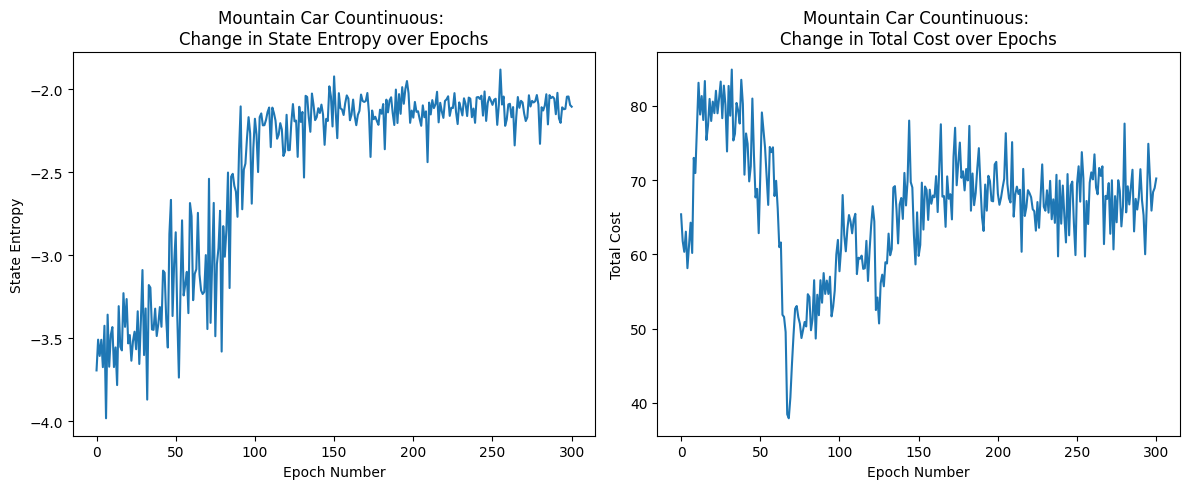

In [35]:
df = pd.read_csv("results/MountainCarContinuous/MEPOL/MountainCarContinuous-v0.csv", index_col = False)
df["cost"] = abs(df["cost"])
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].set_title("Mountain Car Countinuous: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].set_title("Mountain Car Countinuous: \nChange in Total Cost over Epochs")

fig.tight_layout()

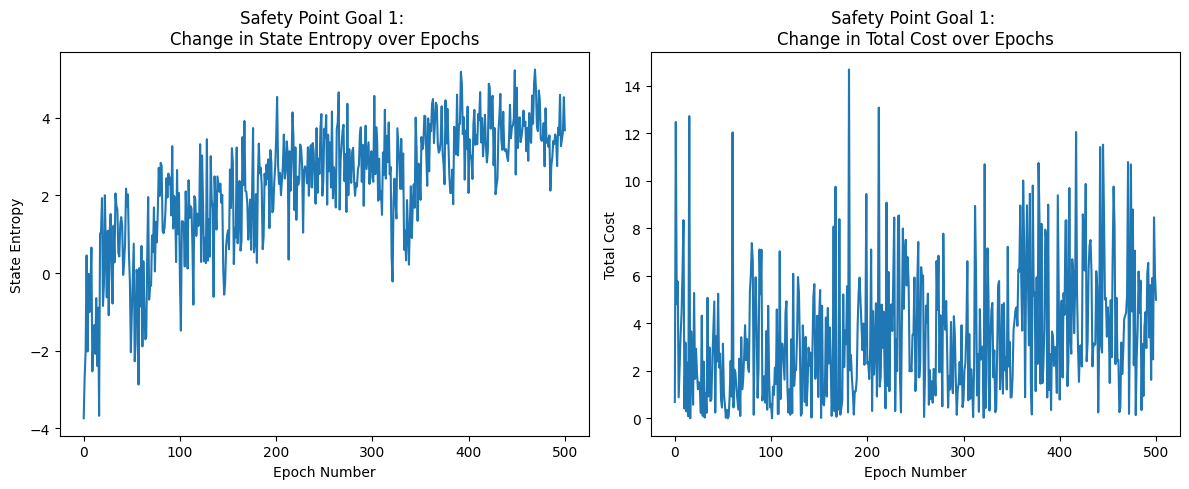

In [36]:
df = pd.read_csv("results/SafetyPointGoal1/MEPOL/SafetyPointGoal1-v0.csv", index_col = False)
df["cost"] = abs(df["cost"])
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].set_title("Safety Point Goal 1: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].set_title("Safety Point Goal 1: \nChange in Total Cost over Epochs")

fig.tight_layout()